In [1]:
from pathlib import Path
import shutil
from py7zr import unpack_7zarchive
import plotly.express as px

%run functions.py

In [2]:
stack = 'cooking'
url = f'https://ia800107.us.archive.org/27/items/stackexchange/{stack}.stackexchange.com.7z'
file_name = f"{stack}.stackexchange.com.7z"
data_dir = Path().cwd().parent / "data" 
export_path = data_dir / f"{stack}"

if not export_path.exists(): 
    export_path.mkdir()

In [3]:
if (data_dir / file_name).exists() == False:
    !wget -P {data_dir}/{file_name} {url}
else:
    print("File already exists")

--2022-11-01 16:54:56--  https://ia800107.us.archive.org/27/items/stackexchange/cooking.stackexchange.com.7z
Resolving ia800107.us.archive.org (ia800107.us.archive.org)... 207.241.232.17
Connecting to ia800107.us.archive.org (ia800107.us.archive.org)|207.241.232.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72662908 (69M) [application/x-7z-compressed]
Saving to: ‘/home/abitporu/Documents/formative-fdsp-apiwizards/data/cooking.stackexchange.com.7z/cooking.stackexchange.com.7z’

cooking.stackexchan 100%[===================>]  69.30M  1.13MB/s    in 55s     

2022-11-01 16:55:52 (1.27 MB/s) - ‘/home/abitporu/Documents/formative-fdsp-apiwizards/data/cooking.stackexchange.com.7z/cooking.stackexchange.com.7z’ saved [72662908/72662908]



In [4]:
shutil.register_unpack_format('7zip', ['.7z'], unpack_7zarchive)

In [6]:
shutil.unpack_archive(data_dir / file_name / file_name, export_path)

In [7]:
xml_file = export_path / "Posts.xml"

df = parse_stackexchange(
    xml_file,
    stack,
    # explode="Tags",
    # keep_columns=["Tags", "AnswerCount", "CommentCount", "FavoriteCount"],
)


/home/abitporu/Documents/formative-fdsp-apiwizards/notebook/functions.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace("<|>", "")
/home/abitporu/Documents/formative-fdsp-apiwizards/notebook/functions.py:38: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 38 of the file /home/abitporu/Documents/formative-fdsp-apiwizards/notebook/functions.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  df["CleanBody"] = df["Body"].apply(lambda x: BeautifulSoup(x).get_text())
/home/abitporu/Documents/formative-fdsp-apiwizards/.venv/lib/python3.10/site-packages/bs4/__init__.py:435: M

In [8]:
df.columns 

Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'CreationDate', 'Score',
       'ViewCount', 'Body', 'OwnerUserId', 'LastEditorUserId', 'LastEditDate',
       'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount',
       'FavoriteCount', 'ContentLicense', 'ParentId', 'ClosedDate',
       'CommunityOwnedDate', 'OwnerDisplayName', 'LastEditorDisplayName',
       'CleanBody', 'ListURL'],
      dtype='object')

In [12]:
# get last creationdate
df["CreationDate"].max()

Timestamp('2022-09-24 16:04:26.537000')

In [9]:
tags = df.explode("Tags") 

In [10]:
# group by month
tags = tags.groupby(["Tags", pd.Grouper(key="CreationDate", freq="M")]).size().reset_index(name="Count")

<AxesSubplot: xlabel='CreationDate'>

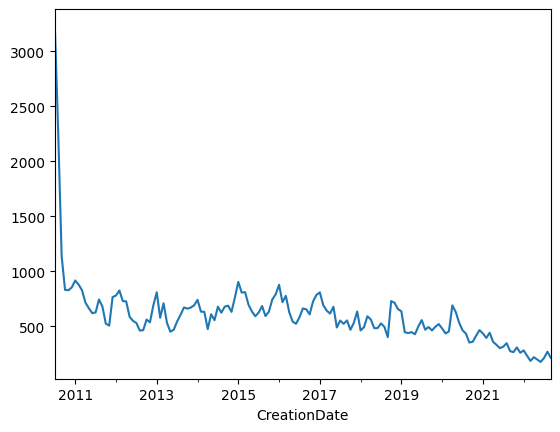

In [14]:
# sum posts per month

df.groupby([pd.Grouper(key="CreationDate", freq="M")]).size().plot()

In [21]:
# filter creation date after 2020
cols = ["CreationDate", "Tags", "ViewCount", "AnswerCount", "CommentCount", "FavoriteCount"]
timeframe = df[df["CreationDate"] >= "2018-01-01"][cols]

In [24]:
timeframe.reset_index().to_feather("sample.feather")

In [11]:
toptags = tags.groupby(["Tags", pd.Grouper(key="CreationDate", freq="Y")]).agg(
    {"AnswerCount": "sum", "CommentCount": "sum", "FavoriteCount": "sum"}
).sort_values("AnswerCount", ascending=False)


KeyError: "Column(s) ['AnswerCount', 'CommentCount', 'FavoriteCount'] do not exist"

In [73]:
toptags_list = toptags.index.get_level_values(0).unique()[:5].tolist()

In [92]:
chart = toptags.loc[toptags.index.get_level_values(0).isin(toptags_list)]

In [93]:
chart  = chart.loc[chart.index.get_level_values(1) > "2012-01-01"]

In [96]:
# plot toptags

fig = px.bar(
    chart.reset_index(),
    x=chart.index.get_level_values(1),
    y="FavoriteCount",
    color="Tags",
    barmode="group",
    title="Top Tags",
    labels={"AnswerCount": "Answer Count", "CreationDate": "Date"},
)

fig.show()